# import all necessary packages for my code to be implemented

In [86]:
import firebase_admin
from firebase_admin import credentials, db
import matplotlib.pyplot as plt
# import matplotlib.ticker as mtick
import os
from dotenv import load_dotenv

### Initialize my own database

In [87]:
# read the variable from .env
load_dotenv()
cred_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

if cred_path is None:
    raise ValueError("GOOGLE_APPLICATION_CREDENTIALS environment variable is not set!")

# initialize my own firebase
if not firebase_admin._apps:
    cred = credentials.Certificate(cred_path)
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://csci526playertrack-default-rtdb.firebaseio.com/'
    })

# fetch my own data
ref = db.reference('/')
data = ref.get()
# print("My current data collected from firebase is: ", data)

# It is time to analyze my data. Before doing so, it is necessary to convert them into the list 
# for further analysis

# results = {}
player_collection = data["players"]

### The first part refers to 2D Map Effectivess associated with this game. The main purpose of solving this concern is to look for whether the 2D map is effective or not.

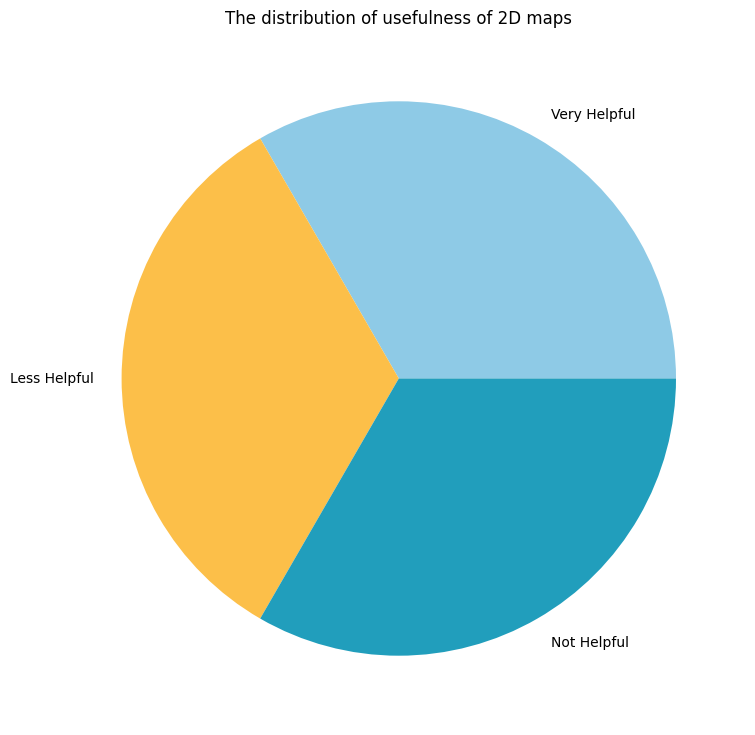

In [88]:
useful2DRes = {}
for player_comb in player_collection:
    if player_comb is not None:
        usefulRes = player_comb['2DUseful']

        if usefulRes not in useful2DRes:
            useful2DRes[usefulRes] = 0
        
        useful2DRes[usefulRes] += 1

# user_times_records_sorted = sorted(user_times_records.items(), key = lambda x: x[0])
# play_times_records = [int(times[0]) for times in user_times_records_sorted]
# user_number_records = [int(times[1]) for times in user_times_records_sorted]
usefulResCategories = list(useful2DRes.keys())
usefulRecords = list(useful2DRes.values())
colors = ["#8ecae6", "#fcbf49", "#219ebc"]

# A pie chart can be drawn, where we really want to determine the distribution of each pie chart 
plt.figure(figsize=(9, 9))
plt.pie(usefulRecords, labels=usefulResCategories, colors= colors)
plt.title("The distribution of usefulness of 2D maps")
plt.show()

### The second metric tests players whether they truly understand the purpose of different game elements, such as Power-ups, Traps, and Magic tiles. For power-ups, we need to track how many users receive Power-ups greater than or equal to 0. As for both traps and magic tiles, we have to evaluate whether the number of times stepping into those elements is greater than or equal to 2.

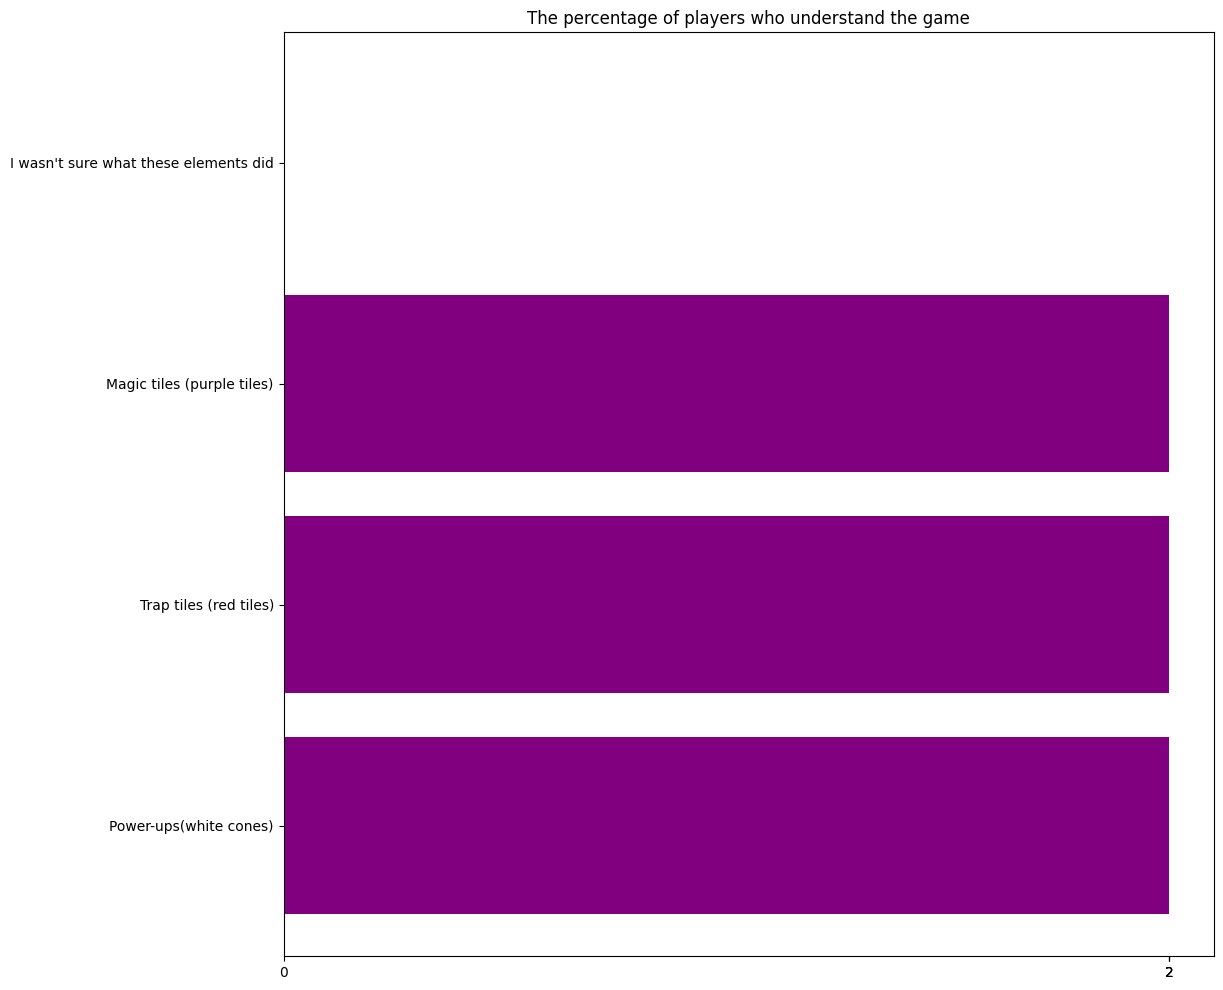

In [89]:

# Three different types of variables used for determining whether players understand the game or not
powerUps_understood = 0  #powerUps
trapTiles_understood = 0 # trapTiles
magicTiles_understood = 0 #magicTiles
no_understood = 0  #no understood

for player_comb in player_collection:
    if player_comb is not None:
        powerUps_considered = player_comb["understandCollectibles"]["powerUps"] # retrieve powerups
        trapTiles_considered = player_comb["understandCollectibles"]["trapTiles"] # retrieve trapTiles
        magicTiles_considered = player_comb["understandCollectibles"]["magicTiles"] #retrieve magicTiles

        # truly understnd  the use of powerUps
        if powerUps_considered > 0:
           powerUps_understood += 1
        
        # truly understand the use of trapTiles
        if trapTiles_considered < 2:
            trapTiles_understood += 1

        # truly understand the use of magicTiles
        if magicTiles_considered < 2:
            magicTiles_understood += 1

         # do not understand all of them
        if powerUps_considered == 0 and trapTiles_considered > 1 and magicTiles_considered > 1:
            no_understood += 1


powerUps_percentage = powerUps_understood / len(player_collection) * 100
trapTiles_percentage = trapTiles_understood / len(player_collection) * 100
magicTiles_percentage = magicTiles_understood / len(player_collection) * 100
no_understood_percentage = no_understood / len(player_collection) * 100

# draw the plot using bar chart
labels = ["Power-ups(white cones)", "Trap tiles (red tiles)", "Magic tiles (purple tiles)", "I wasn't sure what these elements did"]
results = [powerUps_understood, trapTiles_understood, magicTiles_understood, no_understood]

plt.figure(figsize=(12, 12))
bars = plt.barh(labels, results, color="purple")
plt.title("The percentage of players who understand the game")
plt.xticks(results)
plt.show()
        

  

### The third metric is mainly intended to measure the effectivness of wall rotation. The ability to interact with and understand wall rotation is crucial for progressing through levels, especially in a maze where wall positions directly affect player movement.

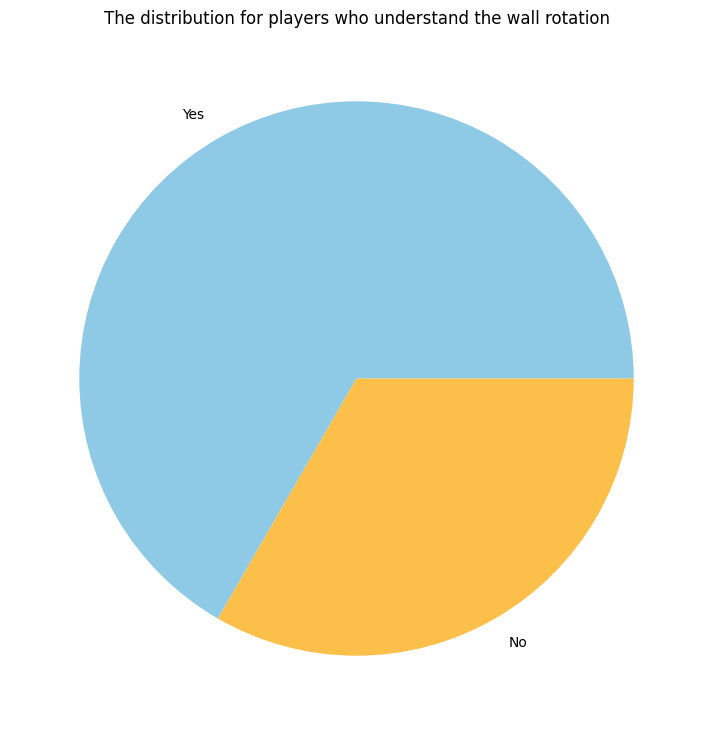

In [90]:
understand_wall_rotation = {}

#iterate each entry to determine the validity of the wall rotation
for player_comb in player_collection:
    
    if player_comb is not None:
      wall_rotation_understood = player_comb["wallRotation"]
        
      if wall_rotation_understood not in understand_wall_rotation:
         understand_wall_rotation[wall_rotation_understood] = 0
      
      understand_wall_rotation[wall_rotation_understood] += 1

# iterate the labels and the values specifically
labels = list(understand_wall_rotation.keys())
values = list(understand_wall_rotation.values())

#draw the plot using pie chart
plt.figure(figsize=(9, 9))
plt.pie(values, labels=labels, colors=["#8ecae6", "#fcbf49"])
plt.title("The distribution for players who understand the wall rotation")
plt.show()

### The last metric is mainly used to determine the level of difficulty of each level. Compared to the previous sessions that we can iterate each individual entry, this metric has to be partitioned in terms of levels, where level 1 corresponds to the level 1's difficulty, level 2 to level 2's difficulty, level 3 to level 3's difficulty, and so on and so forth

In [91]:
level1Res = {}
level1_failure = {}

level2Res = {}
level2_failure = {}


tutorialRes = {}
tutorial_failure = {}

In [92]:

#iterate each entry to determine the validity of the wall rotation
for curr_player in player_collection:

    if curr_player is not None:
        curr_player_records = curr_player["records"]

        # level 1's result
        curr_player_level1 = curr_player_records['level1']
        level1SuccessOrNot = curr_player_level1["completed"]
        
        if level1SuccessOrNot not in level1Res:
            level1Res[level1SuccessOrNot] = 0
        
        level1Res[level1SuccessOrNot] += 1

        # level 1's failure
        if not level1SuccessOrNot:
            reason = curr_player_level1["reason"]

            if reason not in level1_failure:
                level1_failure[reason] = 0
            
            level1_failure[reason] += 1


        
        # level2's result
        curr_player_level2 = curr_player_records['level2']
        level2SuccessOrNot = curr_player_level2["completed"]

        if level2SuccessOrNot not in level2Res:
            level2Res[level2SuccessOrNot] = 0
        
        level2Res[level2SuccessOrNot] += 1

        #level2's failure
        if not level2SuccessOrNot:
            reason = curr_player_level2["reason"]

            if reason not in level2_failure:
                level2_failure[reason] = 0
            
            level2_failure[reason] += 1


        # tutorial's result
        curr_player_tutorial = curr_player_records["tutorial"]
        tutorialSuccessOrNot = curr_player_tutorial["completed"]

        if tutorialSuccessOrNot not in tutorialRes:
            tutorialRes[tutorialSuccessOrNot] = 0
        
        tutorialRes[tutorialSuccessOrNot] += 1

        #level 3's failure
        if not tutorialSuccessOrNot:
            reason = curr_player_tutorial["reason"]

            if reason not in tutorial_failure:
                tutorial_failure[reason] = 0
            
            tutorial_failure[reason] += 1


### Level 1's difficulty ###

#### What percentage of players do succeed and fail in level 1? ####

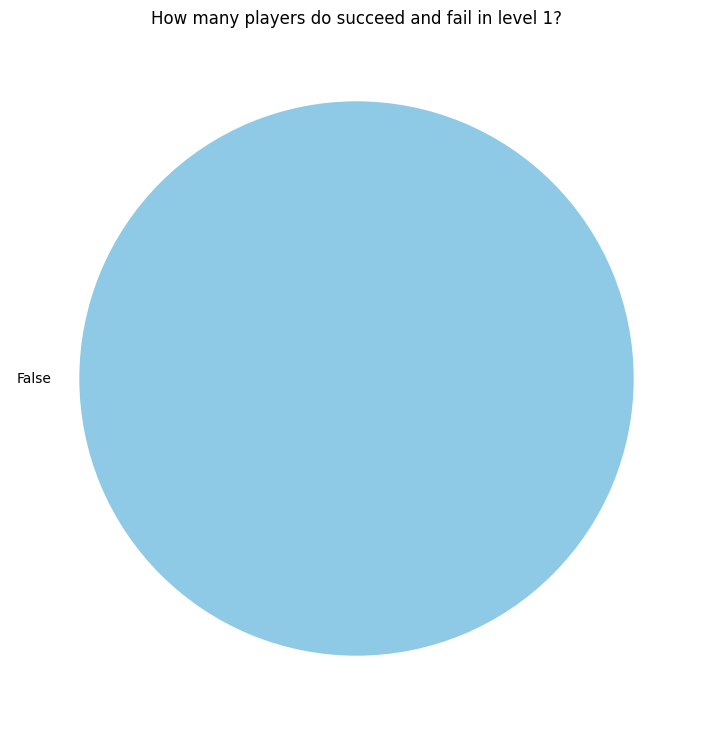

In [93]:
level1_labels = list(level1Res.keys())
level1_values = list(level1Res.values())

# draw the plot using the pie chart
plt.figure(figsize=(9, 9))
plt.pie(level1_values, labels=level1_labels, colors=["#8ecae6", "#fcbf49"])
plt.title("How many players do succeed and fail in level 1?")
plt.show()

#### For those who are failed in level 1, what reason may trigger its failure? ####

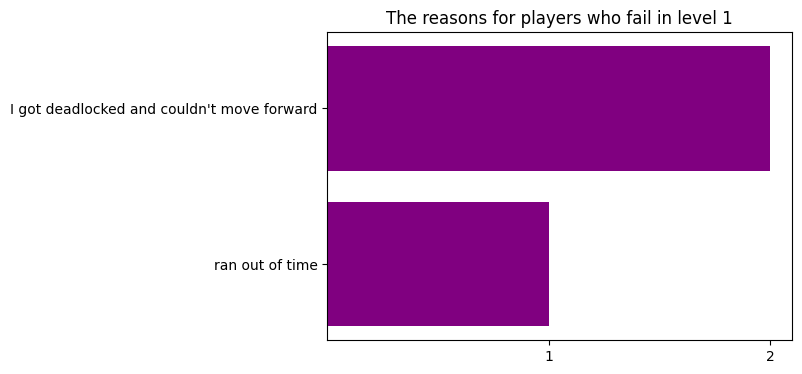

In [94]:
level1_failure_labels = list(level1_failure.keys())
level1_failure_values = list(level1_failure.values())

# draw the plot using the horizontal bar chart
plt.figure(figsize=(6, 4))
bars = plt.barh(level1_failure_labels, level1_failure_values, color="purple")
plt.title("The reasons for players who fail in level 1")
plt.xticks(level1_failure_values)
plt.show()

### Level 2's difficulty ###

#### What percentage of players do succeed and fail in level 2? ####

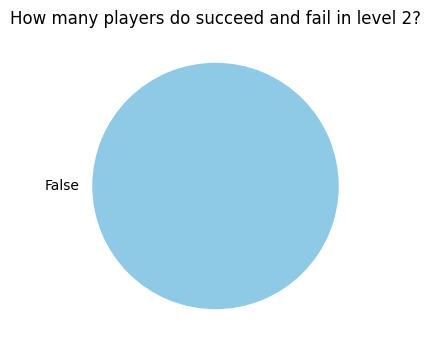

In [95]:
level2_labels = list(level2Res.keys())
level2_values = list(level2Res.values())

# draw the plot using the pie chart
plt.figure(figsize=(6, 4))
plt.pie(level2_values, labels=level2_labels, colors=["#8ecae6", "#fcbf49"])
plt.title("How many players do succeed and fail in level 2?")
plt.show()

#### For those who are failed in level 2, what reason may trigger its failure? ####

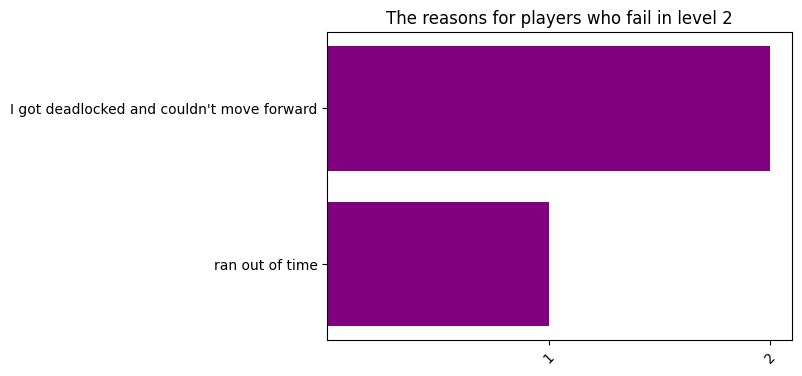

In [96]:
level2_failure_labels = list(level2_failure.keys())
level2_failure_values = list(level2_failure.values())

# draw the plot using the horizontal bar chart
plt.figure(figsize=(6, 4))
bars = plt.barh(level2_failure_labels, level2_failure_values, color="purple")
plt.title("The reasons for players who fail in level 2")
plt.xticks(level2_failure_values, rotation=45)
plt.show()

### Tutorial's difficulty ###

#### What percentage of players do succeed and fail in tutorial section? ####

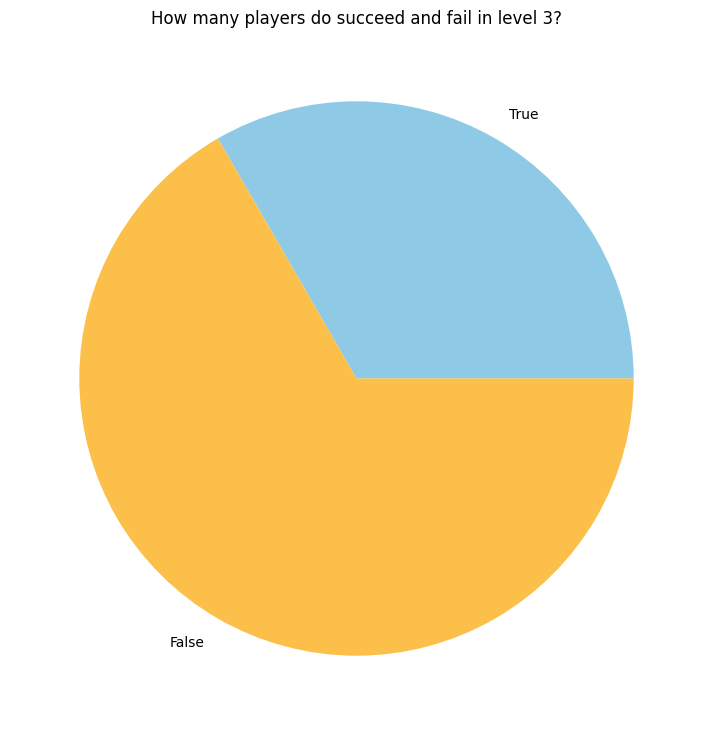

In [97]:
tutorial_labels = list(tutorialRes.keys())
tutorial_values = list(tutorialRes.values())

# draw the plot using the pie chart
plt.figure(figsize=(9, 9))
plt.pie(tutorial_values, labels=tutorial_labels, colors=["#8ecae6", "#fcbf49"])
plt.title("How many players do succeed and fail in level 3?")
plt.show()

#### For those who are failed in level 3, what reason may trigger its failure? ####

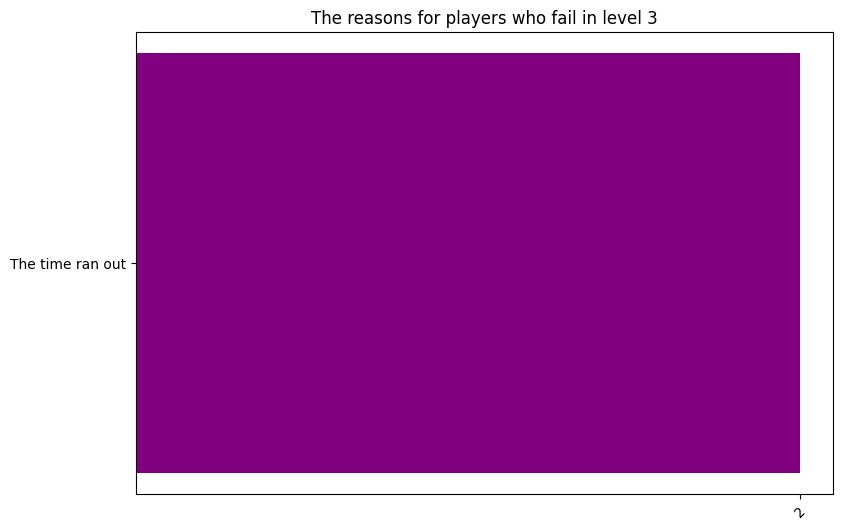

In [98]:
tutorial_failure_labels = list(tutorial_failure.keys())
tutorial_failure_values = list(tutorial_failure.values())

# draw the plot using the horizontal bar chart
plt.figure(figsize=(9, 6))
bars = plt.barh(tutorial_failure_labels, tutorial_failure_values, color="purple")
plt.title("The reasons for players who fail in level 3")
plt.xticks(tutorial_failure_values, rotation=45)
plt.show()